In [1]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm
import bayes3d.tabletop_model
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import Diff

from genjax.generative_functions.distributions import ExactDensity
import bayes3d as b
from dataclasses import dataclass
console = genjax.pretty(show_locals=False)
import matplotlib

2023-06-27 17:23:42.643922: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7015/static/


In [3]:
b.RENDERER = None
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=2.0
)

b.setup_renderer(intrinsics)

cube = b.mesh.make_cuboid_mesh(jnp.array([0.02, 0.02, 0.02]))
b.RENDERER.add_mesh(cube)
cube2 = b.mesh.make_cuboid_mesh(jnp.array([0.1, 0.02, 0.1]))
b.RENDERER.add_mesh(cube2)

table = b.mesh.make_cuboid_mesh(jnp.array([1.0, 1.0, 0.001]))
b.RENDERER.add_mesh(table)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
contact_plane = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 0.6, 0.3]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
root_poses = jnp.tile(contact_plane[None, ...],(4,1,1))
all_box_dims = b.RENDERER.model_box_dims
key = jax.random.PRNGKey(13)

In [5]:
enumerator_trace = lambda trace, key, c: trace.update(
    key,
    genjax.choice_map({
        "contact_params": c, 
    }),
    jtu.tree_map(lambda v: Diff(v, UnknownChange), trace.args),
)[1][2]
enumerator_trace_vmap_jit = jax.jit(jax.vmap(
    enumerator_trace, in_axes=(None, None, 0)))



In [6]:
@genjax.gen
def sample_indices(object, possible_vals):
    b.tabletop_model.uniform_discrete(possible_vals) @ f"id_{i}"

In [7]:

@dataclass
class ContactParamsUniform(ExactDensity):
    def sample(self, key, low, high):
        return jax.random.uniform(key, shape=(1,3)) * (high - low) + low

    def logpdf(self, sampled_val, low, high, **kwargs):
        valid = ((low <= sampled_val) & (sampled_val <= high))
        log_probs = jnp.log((valid * 1.0) * (jnp.ones_like(sampled_val) / (high-low)))
        return log_probs.sum()
contact_params_uniform = ContactParamsUniform()

In [11]:
@genjax.gen
def tabletop_model(array, possible_object_indices, root_poses, all_box_dims, outlier_volume):

    indices = jnp.array([], dtype=jnp.int32)
    contact_params = jnp.zeros((0,3))
    faces_parents = jnp.array([], dtype=jnp.int32)
    faces_child = jnp.array([], dtype=jnp.int32)
    parents = jnp.array([], dtype=jnp.int32)
    for i in range(array.shape[0]):
        index = b.tabletop_model.uniform_discrete(possible_object_indices) @ f"id_{i}"
        indices = jnp.concatenate([indices, jnp.array([index])])
        
        params = contact_params_uniform(
            jnp.array([[-0.2,-0.2, -2*jnp.pi]]), 
            jnp.array([[0.2,0.2, 2*jnp.pi]])) @ f"contact_params_{i}"
        contact_params = jnp.concatenate([contact_params, params])

        parent_obj = b.tabletop_model.uniform_discrete(jnp.arange(-1,array.shape[0] - 1)) @ f"parent_{i}"
        parents = jnp.concatenate([parents, jnp.array([parent_obj])])
        parent_face = b.tabletop_model.uniform_discrete(jnp.arange(0,6)) @ f"face_parent_{i}"
        faces_parents = jnp.concatenate([faces_parents, jnp.array([parent_face])])
        child_face = b.tabletop_model.uniform_discrete(jnp.arange(0,6)) @ f"face_child_{i}"
        faces_child = jnp.concatenate([faces_child, jnp.array([child_face])])
    
    box_dims = all_box_dims[indices]
    poses = b.scene_graph.poses_from_scene_graph(
        root_poses, box_dims, parents, contact_params, faces_parents, faces_child)
    rendered = b.RENDERER.render_jax(
        poses , indices
    )[...,:3]

    variance = genjax.distributions.tfp_uniform(0.00001, 0.1) @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(0.00001, 0.01) @ "outlier_prob"
    image = b.tabletop_model.image_likelihood(rendered, variance, outlier_prob, outlier_volume) @ "image"
    return rendered, indices, poses, image, parents, contact_params, faces_parents, faces_child
importance_jit = jax.jit(tabletop_model.importance)

57306.66
[2 1]
[[0.0148695  0.09750523 0.08485603]]


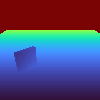

In [65]:
N = 2
key, (_,trace) = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(2),
    "id_1": jnp.int32(1),
    "face_parent_1": jnp.int32(2),
    "face_child_1": jnp.int32(3),
    "variance": 0.00001,
    "outlier_prob": 0.0001,
}), (jnp.arange(N), jnp.arange(3), root_poses[:N], all_box_dims, 10000.0,))
b.clear()
print(trace.get_score())
b.tabletop_model.viz_trace_meshcat(trace)
observed_image = trace.get_retval()[0]
print(trace["contact_params_0"])
b.get_depth_image(observed_image[...,2])

In [ ]:
key, (_,trace) = importance_jit(key, genjax.choice_map({
    "parent_0": -1,
    "parent_1": 0,
    "id_0": jnp.int32(2),
    "id_1": jnp.int32(1),
    "face_parent_1": jnp.int32(2),
    "face_child_1": jnp.int32(3),
    "face_parent_2": jnp.int32(2),
    "face_child_2": jnp.int32(3),
    "variance": 0.00001,
    "outlier_prob": 0.0001,
})

In [141]:
N = 3
choices = trace_.get_choices()
choices["id_2"] = jnp.int32(0)
choices["parent_2"] = jnp.int32(0)
key, (_,trace_) = importance_jit(key, genjax.choice_map({
    choices
}), (jnp.arange(N), jnp.arange(3), root_poses[:N], all_box_dims, 10000.0,))


object_index=2
contact_param_deltas = b.enumerations.make_translation_grid_enumeration_3d(-0.4, -0.4, 0.0, 0.4, 0.4, 0.0, 70, 70, 1)
contact_param_grid = contact_param_deltas
contact_param_full = jnp.tile(trace_["contact_params"][None,...], (contact_param_grid.shape[0],1,1))
contact_param_full = contact_param_full.at[:,object_index].set(contact_param_grid)

traces = enumerator_trace_vmap_jit(trace_, key, contact_param_full)
scores = traces.get_score()
plt.plot(b.utils.normalize_log_scores(scores));

sampled_index = jax.random.categorical(key, scores)
print(sampled_index)
keys = jax.random.split(key, 1)
key = keys[0]
print(traces.slice(sampled_index).get_score())
b.tabletop_model.viz_trace_meshcat(traces.slice(sampled_index))

poses = b.tabletop_model.get_poses(traces)

sampled_indices = jax.random.categorical(key, scores, shape=(500,))

poses_subset = poses[sampled_indices]

img = b.render_point_cloud(poses_subset[:,2,:3,3], intrinsics,pixel_smudge=0.4)
overlay = b.get_depth_image(img[:,:,2], cmap=matplotlib.colormaps['Greys'])

b.scale_image(b.overlay_image(b.get_depth_image(trace_["image"][...,2]), overlay, 0.5), 5.0)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ /tmp/ipykernel_328778/802726590.py:5 in <module>                                                 │
│                                                                                                  │
│ [Errno 2] No such file or directory: '/tmp/ipykernel_328778/802726590.py'                        │
│                                                                                                  │
│ /home/ubuntu/genjax/src/genjax/_src/generative_functions/builtin/builtin_datatypes.py:145 in     │
│ __hash__                                                                                         │
│                                                                                                  │
│   142 │   │   self.trie[k] = v                                                                   │
│   143 │                                                                                          │
│   144 │   def __hash__(self):                                                                    │
│ ❱ 145 │   │   return hash(self.trie)                                                             │
│   146                                                                                            │
│   147                                                                                            │
│   148 ##############                                                                             │
│                                                                                                  │
│ /home/ubuntu/genjax/src/genjax/_src/core/datatypes/trie.py:121 in __hash__                       │
│                                                                                                  │
│   118 │   │   return self.has_subtree(k)                                                         │
│   119 │                                                                                          │
│   120 │   def __hash__(self):                                                                    │
│ ❱ 121 │   │   return hash(self.inner)                                                            │
│   122 │                                                                                          │
│   123 │   def pformat_tree(self, **kwargs):                                                      │
│   124 │   │   tree = rich.tree.Tree(f"[b]{self.__class__.__name__}[/b]")                         │
│                                                                                                  │
│ /home/ubuntu/genjax/src/genjax/_src/core/datatypes/hashabledict.py:29 in __hash__                │
│                                                                                                  │
│   26 │   │   return tuple((k, self[k]) for k in sorted(self))                                    │
│   27 │                                                                                           │
│   28 │   def __hash__(self):                                                                     │
│ ❱ 29 │   │   return hash(self.__key())                                                           │
│   30 │                                                                                           │
│   31 │   def __eq__(self, other):                                                                │
│   32 │   │   return self.__key() == other.__key()                                                │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
TypeError: unhashable type: 'DistributionTrace'